In [59]:
# from qiskit import *
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute, assemble
from qiskit.visualization import plot_histogram, plot_bloch_vector
from qiskit.visualization import plot_state_qsphere, plot_state_city, plot_bloch_multivector
from qiskit.visualization import array_to_latex

# numpy for linear algebra stuff
from numpy.random import randint, shuffle
import numpy as np
import matplotlib.pyplot as plt

# To supress the deprecation warnings
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
%run utility_functions.ipynb

In [135]:
def equatorialqubits(angle=0):

    qc = QuantumCircuit(1)

#     qc.x(0)    
    qc.u(np.pi/2, angle, np.pi, 0)

#     qc.u(0, -angle, 0, 0)
#     qc.u(-np.pi/2, 0, 0, 0)
#     qc.u(0, 0, -np.pi, 0)

    qc.draw(output = 'mpl')

    sim = Aer.get_backend('statevector_simulator')
    job = execute(qc, backend=sim)
    result = job.result()
    sv = result.get_statevector()
    display(plot_bloch_multivector(sv))

    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend)
    result = job.result()
    uni = result.get_unitary(qc, decimals=3)
    display(array_to_latex(uni))


In [137]:
# equatorialqubits(angle = np.pi/2)

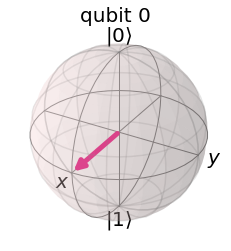

<IPython.core.display.Latex object>

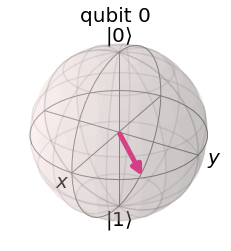

<IPython.core.display.Latex object>

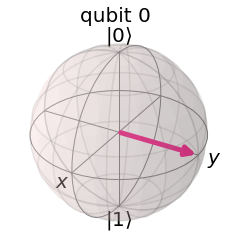

<IPython.core.display.Latex object>

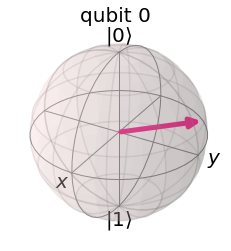

<IPython.core.display.Latex object>

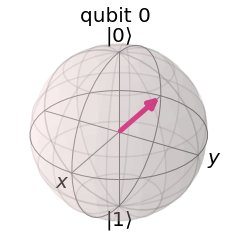

<IPython.core.display.Latex object>

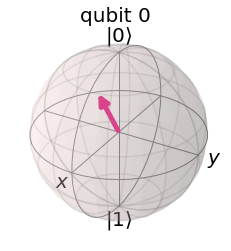

<IPython.core.display.Latex object>

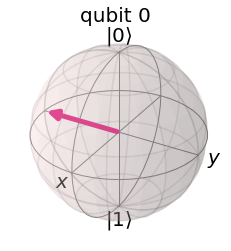

<IPython.core.display.Latex object>

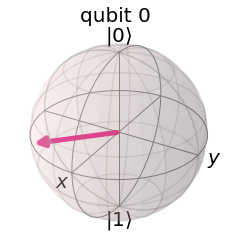

<IPython.core.display.Latex object>

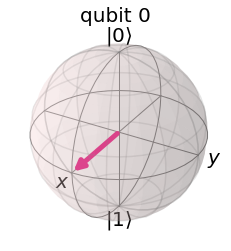

<IPython.core.display.Latex object>

In [132]:
for angle in [0,np.pi/4,np.pi/2,3*np.pi/4,np.pi,5*np.pi/4,3*np.pi/2,7*np.pi/4,2*np.pi]:
    equatorialqubits(angle=angle)

### Cloning circuit for only equatorial bases

In [170]:
def cloningcircuit(alice_bit = 0, alice_base = 0, theta1=np.pi/8):    #only equatorial bases where alice_base represents phi
    
    qr = QuantumRegister(3,'q')
    cr = ClassicalRegister(3,'c')

    qc = QuantumCircuit(qr,cr)
    
#     print("$\phi$ = ", alice_base)
    
    
    if alice_bit == 0:
        qc.u(np.pi/2, alice_base, np.pi, qr[0])
    elif alice_bit == 1:
        qc.x(qr[0])
        qc.u(np.pi/2, alice_base, np.pi, qr[0])
                           
    qc.barrier()

    # theta1=theta3=np.pi/4
    # theta2 = -math.asin(0.5 - math.sqrt(2)/3) ** 0.5
#     theta2 = 0.5 * (np.arccos((np.cos(2*theta1))/(np.sin(2*theta1))))
    
    if theta1 <= np.pi/4:
        theta2 = 0.5 * np.arccos(np.cos(2*theta1)/np.sin(2*theta1))
    if theta1 > np.pi/4:
        theta2 = 0.5 * np.arccos(-np.cos(2*theta1)/np.sin(2*theta1))
        
    theta3 = np.arctan(np.tan(theta1) * np.tan(theta2))
    
    print(theta1,theta2,theta3)
    
    #qc.sdg(y basis)
    
    qc.u(2*theta1,0,0,qr[1])
#     qc.ry(2*theta1,qr[1])
    qc.cx(qr[1],qr[2])
    qc.u(2*theta2,0,0,qr[2])
#     qc.ry(2*theta2,qr[2])
    qc.cx(qr[2],qr[1])
    qc.u(2*theta3,0,0,qr[1])
#     qc.ry(2*theta3,qr[1])
    qc.cx(qr[0],qr[1])
    qc.cx(qr[0],qr[2])
    qc.cx(qr[1],qr[0])
    qc.cx(qr[2],qr[0])

    qc.barrier()
    
    qc.u(0, -alice_base, 0, qr[0])
    qc.u(-np.pi/2, 0, 0, qr[0])
    qc.u(0, 0, -np.pi, qr[0])
    
    qc.u(0, -alice_base, 0, qr[1])
    qc.u(-np.pi/2, 0, 0, qr[1])
    qc.u(0, 0, -np.pi, qr[1])
    
    sim = Aer.get_backend('statevector_simulator')
    job = execute(qc, backend=sim)
    result = job.result()
    sv = result.get_statevector()
    
    qc.measure([0,1],[0,1])
    
#     display(qc.draw(output='mpl'))
    return qc,sv

def displayresult(qc,sv,alice_bit=0,show=True):
    # define the backend
    backend= Aer.get_backend('qasm_simulator')
    # run the simulation
    job = execute(qc, backend=backend, shots = 2048)
    #get the result
    counts = job.result().get_counts()
    
    if show:
        print ("Counts:",counts)

    prob_bob = 0
    prob_alice = 0
    for key in counts.keys():
        if int(list(key)[-1]) == alice_bit:
            prob_bob += counts[key]/2048
        if int(list(key)[-2]) == alice_bit:
            prob_alice += counts[key]/2048
    
    if show:
        print("The probability of Bob measuring the correct bit is ", prob_bob, "and the probability of Alice eavesdropping the correct bit is", prob_alice)
        # plot the histogram of the results
        display(plot_histogram(counts))
        display(plot_bloch_multivector(sv))
        display(array_to_latex(sv))
    
    return prob_bob, prob_alice

### X basis and $\theta_{1}$ = 0.75

0.75 0.7499109550624189 0.7146902134750834


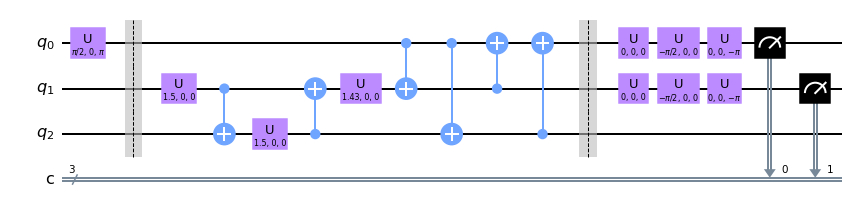

Counts: {'011': 1, '010': 942, '000': 1105}
The probability of Bob measuring the correct bit is  0.99951171875 and the probability of Alice eavesdropping the correct bit is 0.53955078125


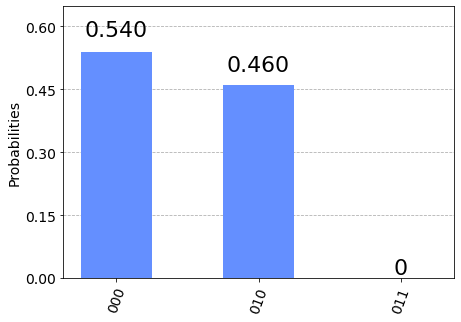

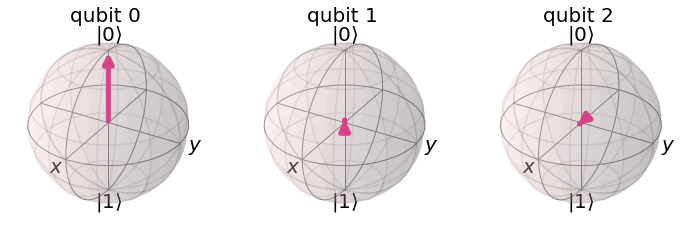

<IPython.core.display.Latex object>

(0.99951171875, 0.53955078125)

In [172]:
qc, sv = cloningcircuit(alice_bit = 0, alice_base = 0, theta1=0.75)
display(qc.draw(output='mpl'))
displayresult(qc,sv,alice_bit=0)

### QBER as a function of $\theta_{1}$ for X basis

In [173]:
theta1s = np.linspace(1.1,2.9,19)
# print(theta1s_)
theta1s = np.pi/8 * theta1s

0.4319689898685966 0.2735077475943141 0.12861598644888833
0.471238898038469 0.37875983784057626 0.2000658653012283
0.5105088062083414 0.45559817472314695 0.2678092835021161
0.5497787143782138 0.5180815686914736 0.33605734678984245
0.5890486225480862 0.5718588702012102 0.40612838223576203
0.6283185307179586 0.6199347554199618 0.4784274379389724
0.6675884388878311 0.6641746723290882 0.5529144025039936
0.7068583470577035 0.7058710510446452 0.6292696520048421
0.7461282552275759 0.7460065734118613 0.7069789058567457
0.7853981633974483 0.7853981633974483 0.7853981633974482
0.8246680715673207 0.7460065734118614 0.7852761041485031
0.8639379797371932 0.7058710510446452 0.7843984042889406
0.9032078879070654 0.6641746723290883 0.7818845151086512
0.9424777960769379 0.6199347554199618 0.7765588841925861
0.9817477042468103 0.5718588702012103 0.7666590146702976
1.0210176124166825 0.518081568691474 0.7492430956053429
1.0602875205865552 0.4555981747231471 0.7187842656757769
1.0995574287564276 0.3787598

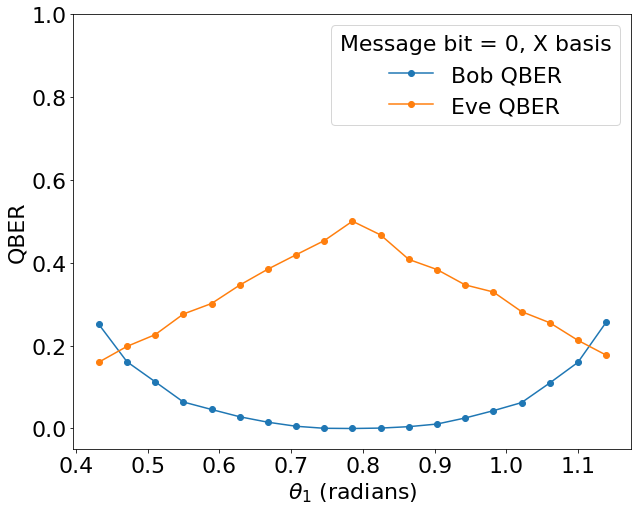

In [174]:
prob_bobs = []
prob_alices = []

err_bobs = []
err_alices = []

for val in theta1s:
#     print("theta1 = ", val)
    qc, sv = cloningcircuit(alice_bit = 0, alice_base = 0, theta1=val)
#     if val == (np.pi/8) * 1.1:
#         display(qc.draw(output='mpl'))
    prob_bob,prob_alice = displayresult(qc,sv,alice_bit=0,show=False)
    prob_bobs.append(prob_bob)
    prob_alices.append(prob_alice)
    err_bobs.append(1-prob_bob)
    err_alices.append(1-prob_alice)

# plt.plot(theta1s,prob_bobs,"-o",label="Bob Accuracy")
# plt.plot(theta1s,prob_alices,"-o",label="Alice Accuracy")


plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 22})

plt.plot(theta1s,err_bobs,"-o",label="Bob QBER")
plt.plot(theta1s,err_alices,"-o",label="Eve QBER")

plt.ylim(-0.05,1)
plt.xlabel(r"$\theta_{1}$ (radians)") #($\times \frac{\pi}{8}$)
plt.ylabel("QBER")

plt.legend(title="Message bit = 0, X basis")
plt.show()

0.4319689898685966 0.2735077475943141 0.12861598644888833
0.471238898038469 0.37875983784057626 0.2000658653012283
0.5105088062083414 0.45559817472314695 0.2678092835021161
0.5497787143782138 0.5180815686914736 0.33605734678984245
0.5890486225480862 0.5718588702012102 0.40612838223576203
0.6283185307179586 0.6199347554199618 0.4784274379389724
0.6675884388878311 0.6641746723290882 0.5529144025039936
0.7068583470577035 0.7058710510446452 0.6292696520048421
0.7461282552275759 0.7460065734118613 0.7069789058567457
0.7853981633974483 0.7853981633974483 0.7853981633974482
0.8246680715673207 0.7460065734118614 0.7852761041485031
0.8639379797371932 0.7058710510446452 0.7843984042889406
0.9032078879070654 0.6641746723290883 0.7818845151086512
0.9424777960769379 0.6199347554199618 0.7765588841925861
0.9817477042468103 0.5718588702012103 0.7666590146702976
1.0210176124166825 0.518081568691474 0.7492430956053429
1.0602875205865552 0.4555981747231471 0.7187842656757769
1.0995574287564276 0.3787598

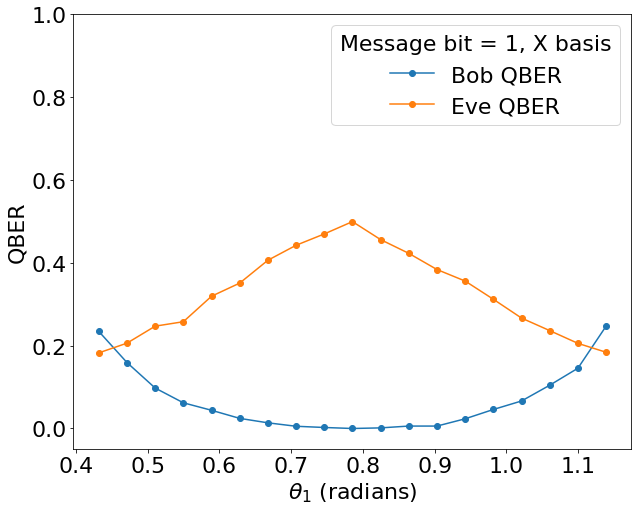

In [176]:
prob_bobs = []
prob_alices = []

err_bobs = []
err_alices = []

for val in theta1s:
#     print("theta1 = ", val)
    qc, sv = cloningcircuit(alice_bit = 1, alice_base = 0, theta1=val)
#     if val == (np.pi/8) * 1.1:
#         display(qc.draw(output='mpl'))
    prob_bob,prob_alice = displayresult(qc,sv,alice_bit=1,show=False)
    prob_bobs.append(prob_bob)
    prob_alices.append(prob_alice)
    err_bobs.append(1-prob_bob)
    err_alices.append(1-prob_alice)

# plt.plot(theta1s,prob_bobs,"-o",label="Bob Accuracy")
# plt.plot(theta1s,prob_alices,"-o",label="Alice Accuracy")


plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 22})

plt.plot(theta1s,err_bobs,"-o",label="Bob QBER")
plt.plot(theta1s,err_alices,"-o",label="Eve QBER")

plt.ylim(-0.05,1)
plt.xlabel(r"$\theta_{1}$ (radians)") #($\times \frac{\pi}{8}$)
plt.ylabel("QBER")

plt.legend(title="Message bit = 1, X basis")
plt.show()

### Y basis and $\theta_{1}$ = 0.75

0.75 0.7499109550624189 0.7146902134750834


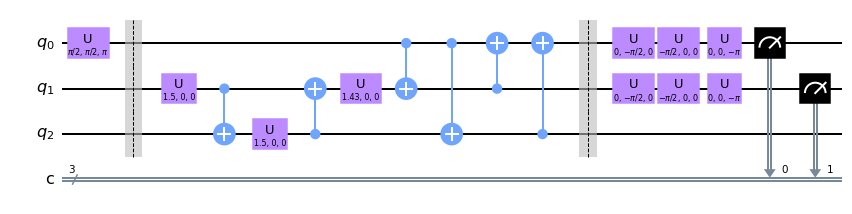

Counts: {'001': 3, '011': 1, '010': 904, '000': 1140}
The probability of Bob measuring the correct bit is  0.998046875 and the probability of Alice eavesdropping the correct bit is 0.55810546875


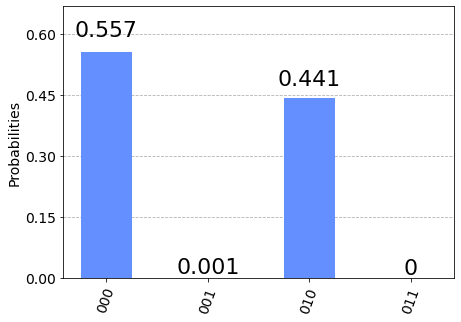

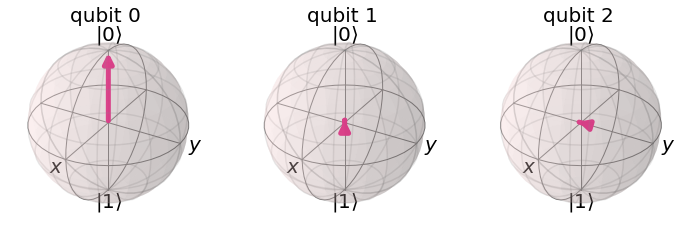

<IPython.core.display.Latex object>

(0.998046875, 0.55810546875)

In [178]:
qc, sv = cloningcircuit(alice_bit = 0, alice_base = (np.pi/2), theta1=0.75)
display(qc.draw(output='mpl'))
displayresult(qc,sv,alice_bit=0)

0.4319689898685966 0.2735077475943141 0.12861598644888833
0.471238898038469 0.37875983784057626 0.2000658653012283
0.5105088062083414 0.45559817472314695 0.2678092835021161
0.5497787143782138 0.5180815686914736 0.33605734678984245
0.5890486225480862 0.5718588702012102 0.40612838223576203
0.6283185307179586 0.6199347554199618 0.4784274379389724
0.6675884388878311 0.6641746723290882 0.5529144025039936
0.7068583470577035 0.7058710510446452 0.6292696520048421
0.7461282552275759 0.7460065734118613 0.7069789058567457
0.7853981633974483 0.7853981633974483 0.7853981633974482
0.8246680715673207 0.7460065734118614 0.7852761041485031
0.8639379797371932 0.7058710510446452 0.7843984042889406
0.9032078879070654 0.6641746723290883 0.7818845151086512
0.9424777960769379 0.6199347554199618 0.7765588841925861
0.9817477042468103 0.5718588702012103 0.7666590146702976
1.0210176124166825 0.518081568691474 0.7492430956053429
1.0602875205865552 0.4555981747231471 0.7187842656757769
1.0995574287564276 0.3787598

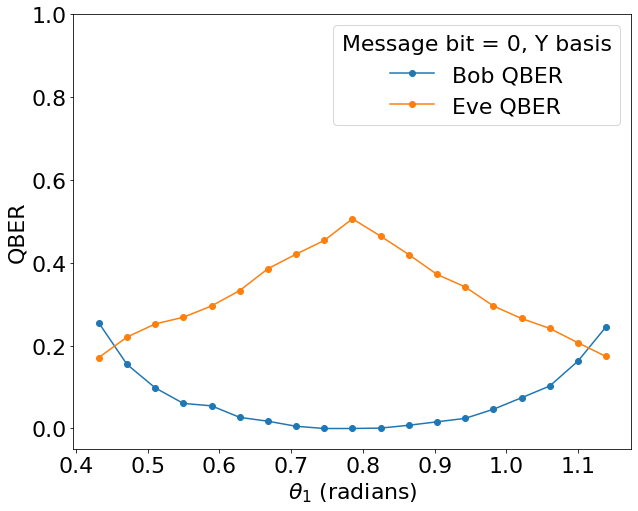

In [179]:
prob_bobs = []
prob_alices = []

err_bobs = []
err_alices = []

for val in theta1s:
#     print("theta1 = ", val)
    qc, sv = cloningcircuit(alice_bit = 0, alice_base = np.pi/2, theta1=val)
#     if val == (np.pi/8) * 1.1:
#         display(qc.draw(output='mpl'))
    prob_bob,prob_alice = displayresult(qc,sv,alice_bit=0,show=False)
    prob_bobs.append(prob_bob)
    prob_alices.append(prob_alice)
    err_bobs.append(1-prob_bob)
    err_alices.append(1-prob_alice)

# plt.plot(theta1s,prob_bobs,"-o",label="Bob Accuracy")
# plt.plot(theta1s,prob_alices,"-o",label="Alice Accuracy")


plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 22})

plt.plot(theta1s,err_bobs,"-o",label="Bob QBER")
plt.plot(theta1s,err_alices,"-o",label="Eve QBER")

plt.ylim(-0.05,1)
plt.xlabel(r"$\theta_{1}$ (radians)") #($\times \frac{\pi}{8}$)
plt.ylabel("QBER")

plt.legend(title="Message bit = 0, Y basis")
plt.show()

0.4319689898685966 0.2735077475943141 0.12861598644888833
0.471238898038469 0.37875983784057626 0.2000658653012283
0.5105088062083414 0.45559817472314695 0.2678092835021161
0.5497787143782138 0.5180815686914736 0.33605734678984245
0.5890486225480862 0.5718588702012102 0.40612838223576203
0.6283185307179586 0.6199347554199618 0.4784274379389724
0.6675884388878311 0.6641746723290882 0.5529144025039936
0.7068583470577035 0.7058710510446452 0.6292696520048421
0.7461282552275759 0.7460065734118613 0.7069789058567457
0.7853981633974483 0.7853981633974483 0.7853981633974482
0.8246680715673207 0.7460065734118614 0.7852761041485031
0.8639379797371932 0.7058710510446452 0.7843984042889406
0.9032078879070654 0.6641746723290883 0.7818845151086512
0.9424777960769379 0.6199347554199618 0.7765588841925861
0.9817477042468103 0.5718588702012103 0.7666590146702976
1.0210176124166825 0.518081568691474 0.7492430956053429
1.0602875205865552 0.4555981747231471 0.7187842656757769
1.0995574287564276 0.3787598

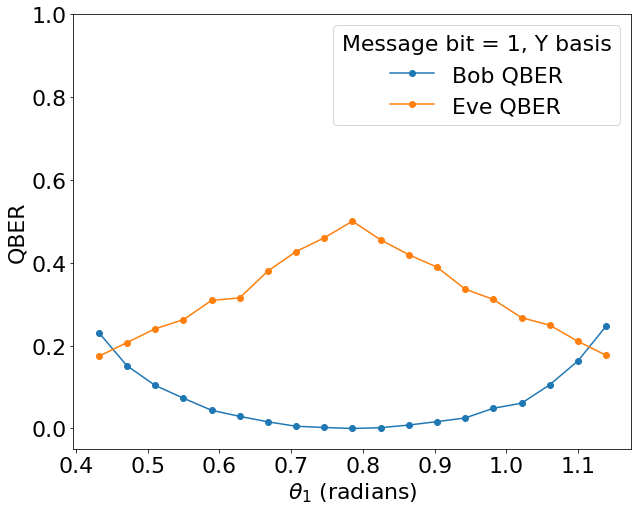

In [181]:
prob_bobs = []
prob_alices = []

err_bobs = []
err_alices = []

for val in theta1s:
#     print("theta1 = ", val)
    qc, sv = cloningcircuit(alice_bit = 1, alice_base = np.pi/2, theta1=val)
#     if val == (np.pi/8) * 1.1:
#         display(qc.draw(output='mpl'))
    prob_bob,prob_alice = displayresult(qc,sv,alice_bit=1,show=False)
    prob_bobs.append(prob_bob)
    prob_alices.append(prob_alice)
    err_bobs.append(1-prob_bob)
    err_alices.append(1-prob_alice)

# plt.plot(theta1s,prob_bobs,"-o",label="Bob Accuracy")
# plt.plot(theta1s,prob_alices,"-o",label="Alice Accuracy")


plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 22})

plt.plot(theta1s,err_bobs,"-o",label="Bob QBER")
plt.plot(theta1s,err_alices,"-o",label="Eve QBER")

plt.ylim(-0.05,1)
plt.xlabel(r"$\theta_{1}$ (radians)") #($\times \frac{\pi}{8}$)
plt.ylabel("QBER")

plt.legend(title="Message bit = 1, Y basis")
plt.show()

### Equatorial basis with $\phi = \pi/4$ and $\theta_{1}$ = 0.75

0.75 0.7499109550624189 0.7146902134750834


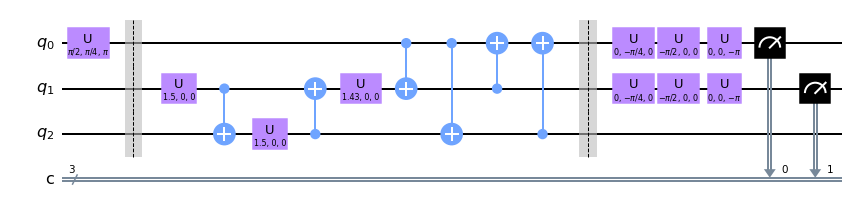

Counts: {'001': 1, '011': 2, '000': 1084, '010': 961}
The probability of Bob measuring the correct bit is  0.99853515625 and the probability of Alice eavesdropping the correct bit is 0.52978515625


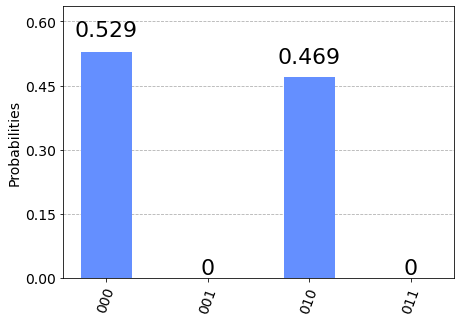

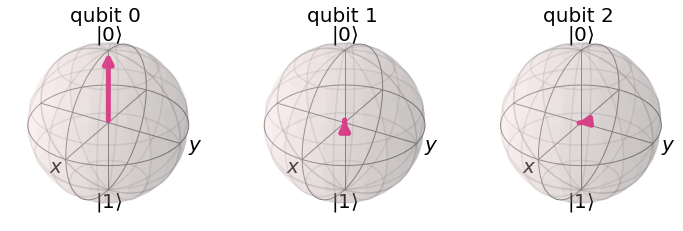

<IPython.core.display.Latex object>

(0.99853515625, 0.52978515625)

In [182]:
qc, sv = cloningcircuit(alice_bit = 0, alice_base = (np.pi/4), theta1=0.75)
display(qc.draw(output='mpl'))
displayresult(qc,sv,alice_bit=0)

0.4319689898685966 0.2735077475943141 0.12861598644888833
0.471238898038469 0.37875983784057626 0.2000658653012283
0.5105088062083414 0.45559817472314695 0.2678092835021161
0.5497787143782138 0.5180815686914736 0.33605734678984245
0.5890486225480862 0.5718588702012102 0.40612838223576203
0.6283185307179586 0.6199347554199618 0.4784274379389724
0.6675884388878311 0.6641746723290882 0.5529144025039936
0.7068583470577035 0.7058710510446452 0.6292696520048421
0.7461282552275759 0.7460065734118613 0.7069789058567457
0.7853981633974483 0.7853981633974483 0.7853981633974482
0.8246680715673207 0.7460065734118614 0.7852761041485031
0.8639379797371932 0.7058710510446452 0.7843984042889406
0.9032078879070654 0.6641746723290883 0.7818845151086512
0.9424777960769379 0.6199347554199618 0.7765588841925861
0.9817477042468103 0.5718588702012103 0.7666590146702976
1.0210176124166825 0.518081568691474 0.7492430956053429
1.0602875205865552 0.4555981747231471 0.7187842656757769
1.0995574287564276 0.3787598

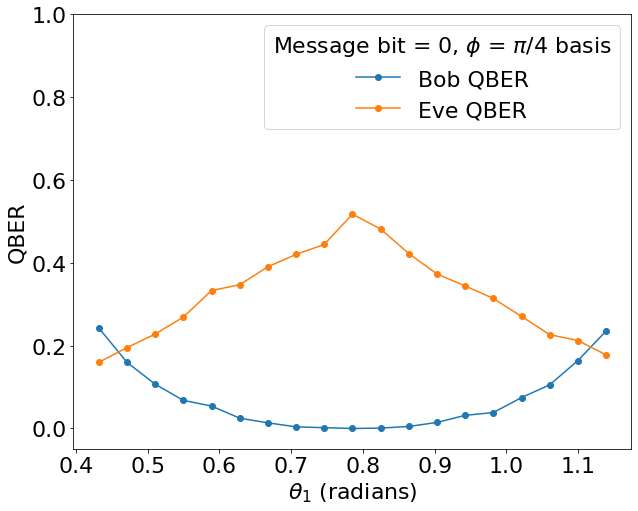

In [190]:
prob_bobs = []
prob_alices = []

err_bobs = []
err_alices = []

for val in theta1s:
#     print("theta1 = ", val)
    qc, sv = cloningcircuit(alice_bit = 0, alice_base = np.pi/4, theta1=val)
#     if val == (np.pi/8) * 1.1:
#         display(qc.draw(output='mpl'))
    prob_bob,prob_alice = displayresult(qc,sv,alice_bit=0,show=False)
    prob_bobs.append(prob_bob)
    prob_alices.append(prob_alice)
    err_bobs.append(1-prob_bob)
    err_alices.append(1-prob_alice)

# plt.plot(theta1s,prob_bobs,"-o",label="Bob Accuracy")
# plt.plot(theta1s,prob_alices,"-o",label="Alice Accuracy")


plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 22})

plt.plot(theta1s,err_bobs,"-o",label="Bob QBER")
plt.plot(theta1s,err_alices,"-o",label="Eve QBER")

plt.ylim(-0.05,1)
plt.xlabel(r"$\theta_{1}$ (radians)") #($\times \frac{\pi}{8}$)
plt.ylabel("QBER")

plt.legend(title="Message bit = 0, $\phi$ = $\pi/4$ basis")
plt.show()

0.4319689898685966 0.2735077475943141 0.12861598644888833
0.471238898038469 0.37875983784057626 0.2000658653012283
0.5105088062083414 0.45559817472314695 0.2678092835021161
0.5497787143782138 0.5180815686914736 0.33605734678984245
0.5890486225480862 0.5718588702012102 0.40612838223576203
0.6283185307179586 0.6199347554199618 0.4784274379389724
0.6675884388878311 0.6641746723290882 0.5529144025039936
0.7068583470577035 0.7058710510446452 0.6292696520048421
0.7461282552275759 0.7460065734118613 0.7069789058567457
0.7853981633974483 0.7853981633974483 0.7853981633974482
0.8246680715673207 0.7460065734118614 0.7852761041485031
0.8639379797371932 0.7058710510446452 0.7843984042889406
0.9032078879070654 0.6641746723290883 0.7818845151086512
0.9424777960769379 0.6199347554199618 0.7765588841925861
0.9817477042468103 0.5718588702012103 0.7666590146702976
1.0210176124166825 0.518081568691474 0.7492430956053429
1.0602875205865552 0.4555981747231471 0.7187842656757769
1.0995574287564276 0.3787598

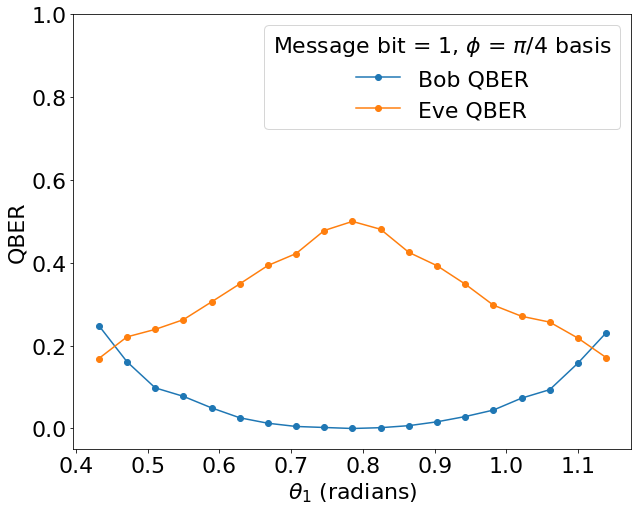

In [192]:
prob_bobs = []
prob_alices = []

err_bobs = []
err_alices = []

for val in theta1s:
#     print("theta1 = ", val)
    qc, sv = cloningcircuit(alice_bit = 1, alice_base = np.pi/4, theta1=val)
#     if val == (np.pi/8) * 1.1:
#         display(qc.draw(output='mpl'))
    prob_bob,prob_alice = displayresult(qc,sv,alice_bit=1,show=False)
    prob_bobs.append(prob_bob)
    prob_alices.append(prob_alice)
    err_bobs.append(1-prob_bob)
    err_alices.append(1-prob_alice)

# plt.plot(theta1s,prob_bobs,"-o",label="Bob Accuracy")
# plt.plot(theta1s,prob_alices,"-o",label="Alice Accuracy")


plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 22})

plt.plot(theta1s,err_bobs,"-o",label="Bob QBER")
plt.plot(theta1s,err_alices,"-o",label="Eve QBER")

plt.ylim(-0.05,1)
plt.xlabel(r"$\theta_{1}$ (radians)") #($\times \frac{\pi}{8}$)
plt.ylabel("QBER")

plt.legend(title="Message bit = 1, $\phi$ = $\pi/4$ basis")
plt.show()

### Cloning circuit with Z and X bases implementation only

In [199]:
def cloningcircuit(alice_bit = 0, alice_base = 0, theta1=np.pi/8):    
    
    qr = QuantumRegister(3,'q')
    cr = ClassicalRegister(3,'c')

    qc = QuantumCircuit(qr,cr)
    
    if alice_bit == 0:
        if alice_base == 0:
            pass
        else:
            qc.h(qr[0])
    elif alice_bit == 1:
        if alice_base == 0:
            qc.x(qr[0])
        else:
            qc.x(qr[0])
            qc.h(qr[0])

                
    qc.barrier()

    # theta1=theta3=np.pi/4
    # theta2 = -math.asin(0.5 - math.sqrt(2)/3) ** 0.5
#     theta2 = 0.5 * (np.arccos((np.cos(2*theta1))/(np.sin(2*theta1))))
    
    if theta1 <= np.pi/4:
        theta2 = 0.5 * np.arccos(np.cos(2*theta1)/np.sin(2*theta1))
    if theta1 > np.pi/4:
        theta2 = 0.5 * np.arccos(-np.cos(2*theta1)/np.sin(2*theta1))
        
    theta3 = np.arctan(np.tan(theta1) * np.tan(theta2))
    
    print(theta1,theta2,theta3)
    
    #qc.sdg(y basis)
    
    qc.u(2*theta1,0,0,qr[1])
#     qc.ry(2*theta1,qr[1])
    qc.cx(qr[1],qr[2])
    qc.u(2*theta2,0,0,qr[2])
#     qc.ry(2*theta2,qr[2])
    qc.cx(qr[2],qr[1])
    qc.u(2*theta3,0,0,qr[1])
#     qc.ry(2*theta3,qr[1])
    qc.cx(qr[0],qr[1])
    qc.cx(qr[0],qr[2])
    qc.cx(qr[1],qr[0])
    qc.cx(qr[2],qr[0])

    qc.barrier()
    
    if alice_base == 0:
        pass
    else:
        qc.h(qr[0])
        qc.h(qr[1])

    
    sim = Aer.get_backend('statevector_simulator')
    job = execute(qc, backend=sim)
    result = job.result()
    sv = result.get_statevector()
    
    qc.measure([0,1],[0,1])
    
#     display(qc.draw(output='mpl'))
    return qc,sv

def displayresult(qc,sv,alice_bit=0,show=True):
    # define the backend
    backend= Aer.get_backend('qasm_simulator')
    # run the simulation
    job = execute(qc, backend=backend, shots = 2048)
    #get the result
    counts = job.result().get_counts()
    
    if show:
        print ("Counts:",counts)

    prob_bob = 0
    prob_alice = 0
    for key in counts.keys():
        if int(list(key)[-1]) == alice_bit:
            prob_bob += counts[key]/2048
        if int(list(key)[-2]) == alice_bit:
            prob_alice += counts[key]/2048
    
    if show:
        print("The probability of Bob measuring the correct bit is ", prob_bob, "and the probability of Alice eavesdropping the correct bit is", prob_alice)
        # plot the histogram of the results
        display(plot_histogram(counts))
        display(plot_bloch_multivector(sv))
        display(array_to_latex(sv))
    
    return prob_bob, prob_alice

### Z basis and $\theta_{1}$ = 0.75

0.75 0.7499109550624189 0.7146902134750834


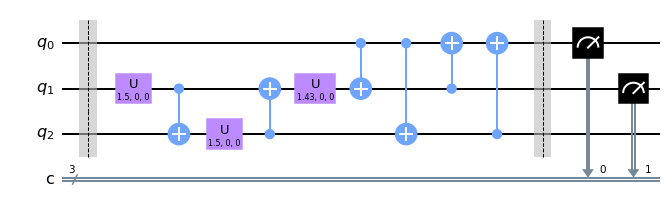

Counts: {'001': 8, '000': 988, '010': 1052}
The probability of Bob measuring the correct bit is  0.99609375 and the probability of Alice eavesdropping the correct bit is 0.486328125


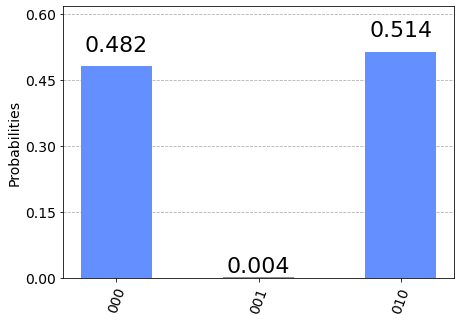

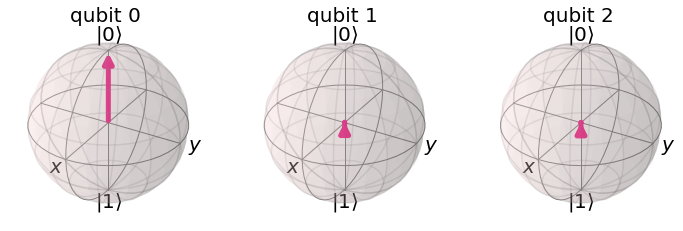

<IPython.core.display.Latex object>

(0.99609375, 0.486328125)

In [200]:
qc, sv = cloningcircuit(alice_bit = 0, alice_base = 0, theta1=0.75)
display(qc.draw(output='mpl'))
displayresult(qc,sv,alice_bit=0)

0.4319689898685966 0.2735077475943141 0.12861598644888833
0.471238898038469 0.37875983784057626 0.2000658653012283
0.5105088062083414 0.45559817472314695 0.2678092835021161
0.5497787143782138 0.5180815686914736 0.33605734678984245
0.5890486225480862 0.5718588702012102 0.40612838223576203
0.6283185307179586 0.6199347554199618 0.4784274379389724
0.6675884388878311 0.6641746723290882 0.5529144025039936
0.7068583470577035 0.7058710510446452 0.6292696520048421
0.7461282552275759 0.7460065734118613 0.7069789058567457
0.7853981633974483 0.7853981633974483 0.7853981633974482
0.8246680715673207 0.7460065734118614 0.7852761041485031
0.8639379797371932 0.7058710510446452 0.7843984042889406
0.9032078879070654 0.6641746723290883 0.7818845151086512
0.9424777960769379 0.6199347554199618 0.7765588841925861
0.9817477042468103 0.5718588702012103 0.7666590146702976
1.0210176124166825 0.518081568691474 0.7492430956053429
1.0602875205865552 0.4555981747231471 0.7187842656757769
1.0995574287564276 0.3787598

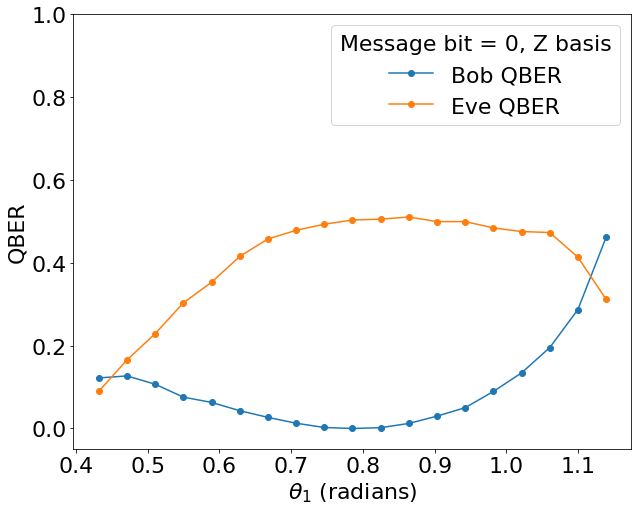

In [201]:
prob_bobs = []
prob_alices = []

err_bobs = []
err_alices = []

for val in theta1s:
#     print("theta1 = ", val)
    qc, sv = cloningcircuit(alice_bit = 0, alice_base = 0, theta1=val)
#     if val == (np.pi/8) * 1.1:
#         display(qc.draw(output='mpl'))
    prob_bob,prob_alice = displayresult(qc,sv,alice_bit=0,show=False)
    prob_bobs.append(prob_bob)
    prob_alices.append(prob_alice)
    err_bobs.append(1-prob_bob)
    err_alices.append(1-prob_alice)

# plt.plot(theta1s,prob_bobs,"-o",label="Bob Accuracy")
# plt.plot(theta1s,prob_alices,"-o",label="Alice Accuracy")


plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 22})

plt.plot(theta1s,err_bobs,"-o",label="Bob QBER")
plt.plot(theta1s,err_alices,"-o",label="Eve QBER")

plt.ylim(-0.05,1)
plt.xlabel(r"$\theta_{1}$ (radians)") #($\times \frac{\pi}{8}$)
plt.ylabel("QBER")

plt.legend(title="Message bit = 0, Z basis")
plt.show()

0.4319689898685966 0.2735077475943141 0.12861598644888833
0.471238898038469 0.37875983784057626 0.2000658653012283
0.5105088062083414 0.45559817472314695 0.2678092835021161
0.5497787143782138 0.5180815686914736 0.33605734678984245
0.5890486225480862 0.5718588702012102 0.40612838223576203
0.6283185307179586 0.6199347554199618 0.4784274379389724
0.6675884388878311 0.6641746723290882 0.5529144025039936
0.7068583470577035 0.7058710510446452 0.6292696520048421
0.7461282552275759 0.7460065734118613 0.7069789058567457
0.7853981633974483 0.7853981633974483 0.7853981633974482
0.8246680715673207 0.7460065734118614 0.7852761041485031
0.8639379797371932 0.7058710510446452 0.7843984042889406
0.9032078879070654 0.6641746723290883 0.7818845151086512
0.9424777960769379 0.6199347554199618 0.7765588841925861
0.9817477042468103 0.5718588702012103 0.7666590146702976
1.0210176124166825 0.518081568691474 0.7492430956053429
1.0602875205865552 0.4555981747231471 0.7187842656757769
1.0995574287564276 0.3787598

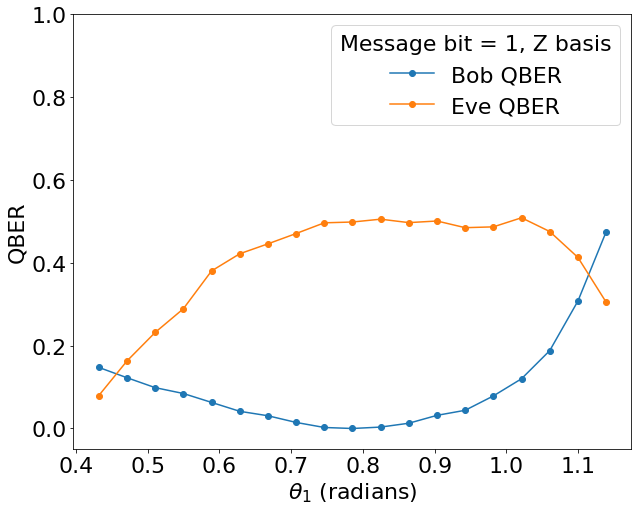

In [202]:
prob_bobs = []
prob_alices = []

err_bobs = []
err_alices = []

for val in theta1s:
#     print("theta1 = ", val)
    qc, sv = cloningcircuit(alice_bit = 1, alice_base = 0, theta1=val)
#     if val == (np.pi/8) * 1.1:
#         display(qc.draw(output='mpl'))
    prob_bob,prob_alice = displayresult(qc,sv,alice_bit=1,show=False)
    prob_bobs.append(prob_bob)
    prob_alices.append(prob_alice)
    err_bobs.append(1-prob_bob)
    err_alices.append(1-prob_alice)

# plt.plot(theta1s,prob_bobs,"-o",label="Bob Accuracy")
# plt.plot(theta1s,prob_alices,"-o",label="Alice Accuracy")


plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 22})

plt.plot(theta1s,err_bobs,"-o",label="Bob QBER")
plt.plot(theta1s,err_alices,"-o",label="Eve QBER")

plt.ylim(-0.05,1)
plt.xlabel(r"$\theta_{1}$ (radians)") #($\times \frac{\pi}{8}$)
plt.ylabel("QBER")

plt.legend(title="Message bit = 1, Z basis")
plt.show()